In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt




/var/folders/yl/gn9fldpj69169vhn466y4klh0000gn/T/ipykernel_1934/3171848483.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,RSI,MACD_Strategy,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
13,394.579987,395.119995,394.130005,394.309998,6686622,394.568088,394.632682,-0.064594,-0.056549,-0.008045,45.722128,NaN,NaN,NaN,0,NaN,NaN
14,397.119995,397.440002,395.152710,396.500000,10901733,394.995576,394.897469,0.098107,-0.024490,0.122597,57.549363,-1.0,0.0,-1.0,0,0.006437,0.000000
15,397.359985,397.790100,396.570007,397.135010,6645186,395.386314,395.150745,0.235569,0.029028,0.206540,57.910352,1.0,0.0,1.0,0,0.007045,0.000000
16,397.480011,397.890015,396.820007,397.350006,4518030,395.728410,395.383017,0.345393,0.093759,0.251634,67.451022,1.0,0.0,1.0,0,0.007350,0.000000
17,398.440002,398.540009,397.329987,397.459991,3722601,396.167276,395.679469,0.487807,0.174014,0.313792,67.934789,1.0,-1.0,0.0,0,0.009783,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,663.109985,663.359985,658.140015,659.440002,10154976,662.164453,663.191575,-1.027122,-0.822184,-0.204937,46.181977,-1.0,1.0,0.0,0,0.680546,-0.041302
5078,661.190002,663.635010,660.549988,663.130005,6951317,662.014538,663.048605,-1.034068,-0.864561,-0.169507,50.556183,-1.0,0.0,-1.0,0,0.675681,-0.041302
5079,664.630005,665.039978,660.710022,661.159973,8819016,662.416917,663.161562,-0.744645,-0.840578,0.095933,50.537867,-1.0,0.0,-1.0,0,0.684399,-0.041302
5080,665.130005,665.755005,664.030029,664.650024,8491669,662.834315,663.302165,-0.467850,-0.766032,0.298182,49.604954,1.0,0.0,1.0,0,0.685666,-0.041302


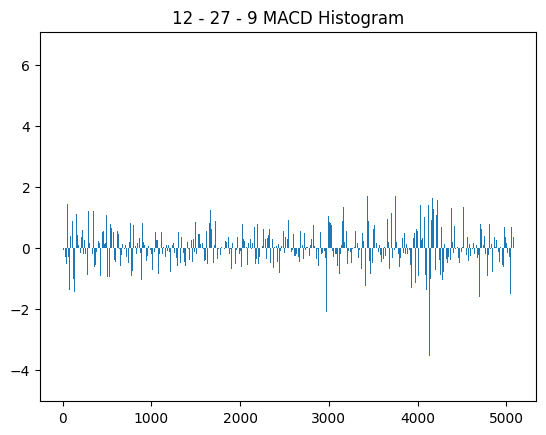

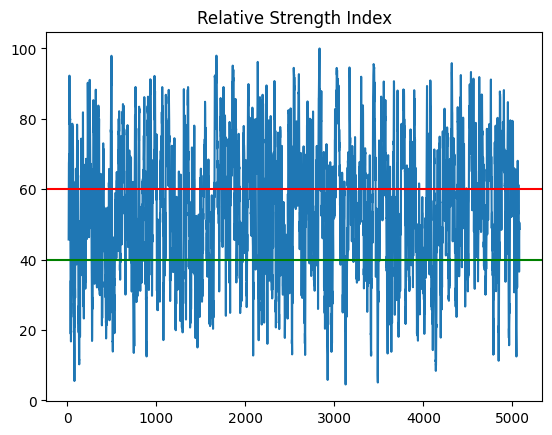

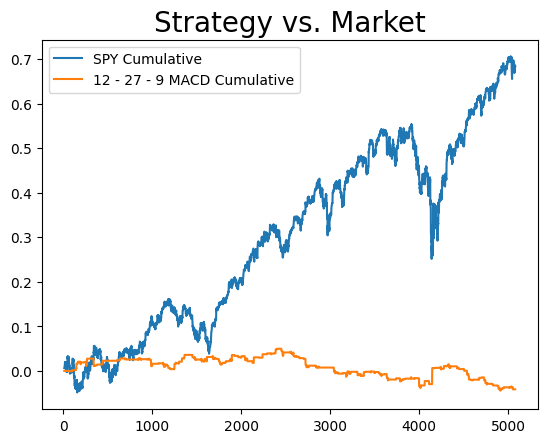

In [23]:
TICKER = 'SPY'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_MACD_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

In [21]:
df['Full_Strategy'].value_counts()

Full_Strategy
 0.0    970
-1.0    513
 1.0    353
-2.0     81
 2.0     19
Name: count, dtype: int64